Read the whole dataset and take a sample from it.

In [1]:
import pandas as pd

# Read the dataset into a Pandas DataFrame
df = pd.read_csv('Kaagle_Upload.csv')
df = df.sample(frac=0.005)



C:\Users\emrey\AppData\Local\Temp\ipykernel_20200\2789285195.py:4: DtypeWarning: Columns (0,55) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('Kaagle_Upload.csv')


We must remove some columns that are NOT necessary. 
Also, the column "Age of Casualty" is not helpful since it does not carry a data

In [2]:
# Remove "driver imd decile" column and corresponding data
df = df.drop(["driver_imd_decile"], axis=1)

# Remove "Introduction" column and corresponding data (assuming it's a typo and you meant "accident_index")
df = df.drop(["accident_index"], axis=1)

# Remove "Age of Casualty" column and corresponding data
df = df.drop(["age_of_casualty"], axis=1)

# Remove "Propulsion Code" column and corresponding data
df = df.drop(["propulsion_code"], axis=1)



We have a lot of missing attribute values. We can follow different approaches to solve the problem.
In this case, I chose the remove some data rows. If a row has 7 or more NA values I removed them from dataset since it may be difficult and meaningless to fill their NA columns.

In [3]:
# Remove rows with more than 7 NA values
df = df.dropna(thresh=df.shape[1]-7)

# Resetting the index after removing rows
df = df.reset_index(drop=True)


Let's see the first 10 and last 10 rows with last 10 columns

In [4]:
# Print first 10 rows with last 10 columns
print(df.iloc[:10, -10:])


   age_band_of_casualty  casualty_severity  pedestrian_location  \
0                   9.0                3.0                  0.0   
1                   6.0                3.0                  0.0   
2                   6.0                3.0                  0.0   
3                   3.0                3.0                  0.0   
4                   7.0                3.0                  0.0   
5                   5.0                3.0                  0.0   
6                   5.0                3.0                  0.0   
7                   9.0                3.0                  6.0   
8                   7.0                3.0                  0.0   
9                   4.0                2.0                  0.0   

   pedestrian_movement  car_passenger  bus_or_coach_passenger  \
0                  0.0            1.0                     0.0   
1                  0.0            1.0                     0.0   
2                  0.0            0.0                     0.0   
3 

We removed rows that has more than 7 NA values. But, we still have missing values. This is my approach to solve remaining missing data:
1. Indicate columns that has at least 1 missing values
2. Find correlation of those columns with any other columns
3. Indicate top 10 correlated columns with the columns that have missing values
4. Iterate all rows and columns, and fill missing values by taking mods of rows that has top 10 correlated columns of data 

In [5]:
# Get the number of rows in the DataFrame
num_rows = df.shape[0]

# Print the result
print("Number of rows that has missing values:", num_rows)

# Identify columns with at least one -1 value
columns_with_minus_one = df.columns[df.isin([-1]).any()]

# Print the columns
print("Columns that has missing values: ",columns_with_minus_one)

Number of rows that has missing values: 926
Columns that has missing values:  Index(['towing_and_articulation', 'was_vehicle_left_hand_drive?',
       'journey_purpose_of_driver', 'age_of_driver', 'age_band_of_driver',
       'engine_capacity_(cc)', 'age_of_vehicle', 'driver_home_area_type',
       'vehicle_imd_decile', 'junction_control', '2nd_road_class',
       '2nd_road_number', 'pedestrian_crossing-human_control',
       'pedestrian_crossing-physical_facilities', 'road_surface_conditions',
       'did_police_officer_attend_scene_of_accident', 'age_band_of_casualty',
       'car_passenger', 'casualty_home_area_type', 'casualty_imd_decile'],
      dtype='object')


Chi-Square Statistic and Cramer's V
Chi-Square Statistic:
The Chi-Square test is used to test the degree of independence between two categorical variables. If the variables are independent, there should not be a significant difference between the observed frequencies and the expected frequencies.

Cramer's V:
Cramer's V is a statistic measuring the strength of association between two categorical variables. It ranges from 0 to 1, where 0 indicates independence, and 1 indicates a perfect association. Cramer's V is based on the Chi-Square statistic and is not affected by the number of categories in the variables.

Steps of the Code
chi2_contingency_custom_fixed Function:

Parameter: confusion_matrix, which contains the observed frequencies between two categorical variables.
Total Observations (n): The sum of all values in the matrix.
Row and Column Totals: The sum of each row and column is calculated.
Expected Frequencies (expected): The expected frequency for each cell is calculated. This is done by multiplying the corresponding row and column totals and dividing by the total number of observations.
Chi-Squared Statistic (chi2): The squared difference between observed and expected frequencies is divided by the expected frequencies and summed over all cells.

cramers_v Function:
Parameter: confusion_matrix (as a pandas DataFrame).
Chi-Squared Statistic: Calculated using the chi2_contingency function defined above.
Phi2 and Corrections:
Phi2 is calculated by dividing the chi-squared value by the total number of observations.
Corrections are applied to reduce the influence of the sample size.
Cramer's V Value: Calculated by taking the square root of the corrected Phi2 divided by the minimum of the corrected number of rows and columns minus one.

cramers_v_for_column Function:
Parameters: df (DataFrame) and column (the column you want to examine).

Calculating Correlation Values:
A contingency table is created for each other column with the specified column.
Cramer's V value is calculated for each contingency table.
Result: Returns an array of Cramer's V values, indicating the strength of the relationship between the specified column and other columns in the DataFrame.
These functions are useful in categorical data analysis and provide essential tools for understanding the strength of relationships between variables. They are particularly valuable in datasets with many categorical variables to determine which variables have stronger associations with each other.

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import chi2_contingency
import re


def chi2_contingency(confusion_matrix):
    # Calculate total observations
    n = confusion_matrix.sum()

    # Row and Column totals
    row_sums = confusion_matrix.sum(axis=1)
    col_sums = confusion_matrix.sum(axis=0)

    # Initialize expected frequency matrix
    expected = np.zeros_like(confusion_matrix, dtype=float)

    # Calculate expected frequency for each cell
    for i in range(confusion_matrix.shape[0]):
        for j in range(confusion_matrix.shape[1]):
            expected[i, j] = (row_sums[i] * col_sums[j]) / n

    # Chi-squared statistic
    chi2 = ((confusion_matrix - expected) ** 2 / expected).sum()

    return chi2, expected


def cramers_v(confusion_matrix):
    """
    Parameters:
    confusion_matrix (pandas.DataFrame): The contingency table as a DataFrame.

    Returns:
    float: Cramer's V statistic.
    """
    # Convert the DataFrame to a numpy array for processing
    confusion_matrix_np = confusion_matrix.to_numpy()

    # Compute chi-squared statistic
    chi2, expected_np = chi2_contingency(confusion_matrix_np)
    
    # Ensure there are no zeros in expected frequencies to avoid division by zero
    if np.any(expected_np == 0):
        return 0

    n = confusion_matrix_np.sum()
    phi2 = chi2 / n
    r, k = confusion_matrix_np.shape
    phi2corr = max(0, phi2 - ((k - 1) * (r - 1)) / (n - 1))
    rcorr = r - ((r - 1) ** 2) / (n - 1)
    kcorr = k - ((k - 1) ** 2) / (n - 1)
    return np.sqrt(phi2corr / min((kcorr - 1), (rcorr - 1)))

def cramers_v_for_column(df, column):
    correlation_values = []
    
    for other_column in df.columns:
        if other_column != column:
            confusion_matrix = pd.crosstab(df[column], df[other_column])
            correlation_value = cramers_v(confusion_matrix)
            correlation_values.append(correlation_value)

    return correlation_values

# Columns that has at least 1 missing value
target_columns = ['vehicle_type', 'towing_and_articulation', 'vehicle_manoeuvre',
       'vehicle_location-restricted_lane', 'junction_location',
       'skidding_and_overturning', 'hit_object_in_carriageway',
       'vehicle_leaving_carriageway', 'hit_object_off_carriageway',
       '1st_point_of_impact', 'was_vehicle_left_hand_drive?',
       'journey_purpose_of_driver', 'sex_of_driver', 'age_of_driver',
       'age_band_of_driver', 'engine_capacity_(cc)', 'age_of_vehicle',
       'driver_home_area_type', 'vehicle_imd_decile', 'junction_control',
       '2nd_road_class', '2nd_road_number',
       'pedestrian_crossing-human_control',
       'pedestrian_crossing-physical_facilities', 'road_surface_conditions',
       'special_conditions_at_site', 'carriageway_hazards',
       'did_police_officer_attend_scene_of_accident', 'sex_of_casualty',
       'age_band_of_casualty', 'car_passenger', 'bus_or_coach_passenger',
       'pedestrian_road_maintenance_worker', 'casualty_home_area_type',
       'casualty_imd_decile']

# Create dictionary to store Cramer's V values
correlation_matrix_dict = {}

# Calulate Cramer's V for every column and add them to the matrix
for column in target_columns:
    correlation_values = cramers_v_for_column(df, column)
    correlation_matrix_dict[column] = correlation_values

    correlation_df = pd.DataFrame({
        'Other_Column': [col for col in df.columns if col != column],
        'Cramers_V': correlation_values
    })
    
    plt.figure(figsize=(60, 60))
    sns.barplot(x='Other_Column', y='Cramers_V', data=correlation_df)
    plt.title(f"{column} ile Diğer Sütunlar Arasındaki Cramer's V Korelasyonu (En Yüksek 5)")
    plt.xticks(rotation=45)
    # PNG olarak kaydet
    plt.savefig(f"{column.replace('?', '')}_correlation.png", bbox_inches='tight')
    


Find the most correlated column for each column that has at least one missing value

In [7]:
import pandas as pd

def top_correlated_categories(df, target_column, num_top_categories=3):
    correlation_values = []

    for other_column in df.columns:
        if other_column != target_column:
            confusion_matrix = pd.crosstab(df[target_column], df[other_column])
            correlation_value = cramers_v(confusion_matrix)
            correlation_values.append((other_column, correlation_value))

    correlation_values.sort(key=lambda x: x[1], reverse=True)
    top_categories = [item[0] for item in correlation_values[:num_top_categories]]

    return top_categories

# Iterate all data
for index, row in df.iterrows():
    for column in df.columns:
        if row[column] == -1:
            # Pair each correlation value with its corresponding column name
            correlated_columns_with_values = list(zip(df.columns, correlation_matrix_dict[column]))

            # Remove entries with 'nan' values and sort the rest
            correlated_columns_with_values = [item for item in correlated_columns_with_values if not pd.isna(item[1])]
            correlated_columns_with_values.sort(key=lambda x: x[1], reverse=True)

            # Select top 5 correlated columns
            top_correlated_columns = [col[0] for col in correlated_columns_with_values[:5]]

            # Create a combined filter condition for top correlated columns
            filter_conditions = [df[corr_col] == row[corr_col] for corr_col in top_correlated_columns if corr_col in df.columns]
            if filter_conditions:
                combined_filter = np.logical_and.reduce(filter_conditions)

                # Apply the filter to find relevant rows, excluding the current row with -1
                relevant_rows = df[combined_filter & (df.index != index)]

                # Get mode and fill the missing value
                if not relevant_rows.empty:
                    mode_value = relevant_rows[column].mode().iloc[0]
                    df.at[index, column] = mode_value
                else:
                    df.at[index, column] = 0
            else:
                # If no correlated columns are found, use mode of the entire column
                mode_value = df[column].mode().iloc[0]
                if(mode_value==-1):
                    mode_value = 0
                df.at[index, column] = mode_value


# Let's check the results and generate new output
print(df)
df.to_csv('new_data.csv', index=False)
df = pd.read_csv('new_data.csv')


     vehicle_reference  vehicle_type  towing_and_articulation  \
0                    1             9                        0   
1                    1             8                        0   
2                    2             9                        0   
3                    1             3                        0   
4                    2             9                        0   
..                 ...           ...                      ...   
921                  2             1                        0   
922                  1             1                        0   
923                  1             9                        0   
924                  1             9                        0   
925                  1             9                        0   

     vehicle_manoeuvre  vehicle_location-restricted_lane  junction_location  \
0                    9                                 0                  6   
1                    4                                 0     

Classification

This code snippet implements the fundamental steps of a decision tree algorithm. A decision tree is a popular machine learning model used for classification and regression problems. This algorithm uses metrics like the Gini Index and Entropy to determine the best features and threshold values that best split the dataset. Below is an explanation of each step of the code:

Gini Index and Entropy
Gini Index:
The Gini Index measures the purity (homogeneity) of a dataset at each node of a decision tree. Its value ranges from 0 to 1, where 0 indicates complete purity (homogeneity), and 1 indicates complete heterogeneity.

Entropy:
Entropy is a measure of the disorder or uncertainty in a dataset. A lower entropy value indicates a more orderly dataset (less uncertainty), while a higher value indicates more disorder.

Information Gain:
Information Gain is the amount of "purity increase" achieved by splitting a dataset based on a feature. A feature with high information gain is a good candidate for a node in the decision tree.

Steps of the Code

check_purity Function:
Checks if the data split is pure (only one class remains).

classify_data Function:
Classifies data by majority vote.

get_potential_splits Function:
Determines potential splitting points for the data.

split_data Function:
Splits the data into two parts based on a threshold value.

calculate_entropy and calculate_gini Functions:
Calculates the entropy or Gini Index of a particular split.

calculate_overall_gini Function:
Calculates the weighted metric (Gini/Entropy) of two splits.

determine_best_split Function:
Determines the best split using the specified metric (Gini/Entropy).

DecisionNode Class:
Represents each node of the decision tree.

decision_tree_algorithm Function:
Implements the fundamental steps of the decision tree algorithm. It first checks if the dataset is pure, then determines the best split, and recursively constructs each subtree of the tree.
Decision Tree Algorithm
This code constructs a decision tree by splitting the dataset in a way that maximizes the purity of the dataset. At each step, the best split for the current dataset (the feature and threshold value yielding the highest information gain) is found using the Gini Index or Entropy. The dataset is then split into two subsets based on this threshold value, and the process is recursively repeated for each subset. This continues until the dataset becomes pure or the maximum depth is reached.


In [8]:
class_weights = {1: 1, 2: 5, 3: 500}


def calculate_weighted_metric(data, metric_function):
    """ Calculate the weighted metric (Gini/Entropy) for the data. """
    labels = data[:, -1]
    unique_classes, counts = np.unique(labels, return_counts=True)
    weights = [class_weights[cls] for cls in unique_classes]
    
    # Apply weights to the counts
    weighted_counts = counts * weights
    weighted_probabilities = weighted_counts / weighted_counts.sum()
    
    return metric_function(weighted_probabilities)

def check_purity(data):
    """ Check if the data split is pure (only one class remains). """
    unique_classes = np.unique(data[:, -1])
    if len(unique_classes) == 1:
        return True
    else:
        return False

def classify_data(data):
    """ Classify data by majority vote. """
    if len(data) == 0:
        return
    
    unique_classes, counts_unique_classes = np.unique(data[:, -1], return_counts=True)
    index = counts_unique_classes.argmax()
    classification = unique_classes[index]
    return classification

def get_potential_splits(data):
    """ Get potential splits for the data. """
    potential_splits = {}
    _, n_columns = data.shape
    for column_index in range(n_columns - 1):  # excluding the last column which is the label
        values = data[:, column_index]
        unique_values = np.unique(values)
        
        potential_splits[column_index] = unique_values
    
    return potential_splits

def split_data(data, split_column, split_value):
    """ Split data into two parts based on the split value. """
    split_column_values = data[:, split_column]

    data_below = data[split_column_values <= split_value]
    data_above = data[split_column_values > split_value]
    
    return data_below, data_above

# categorical features into a binary numeric format which does not require changes.
def calculate_entropy(probabilities):
    """ Calculate entropy given probabilities. """
    return sum(probabilities * -np.log2(probabilities + 1e-9))  # Avoid log(0)


def calculate_gini(probabilities):
    """ Calculate Gini Impurity given probabilities. """
    return 1 - sum(probabilities ** 2)

def calculate_overall(data_below, data_above, metric_function):
    """ Calculate the weighted metric (Gini/Entropy) of two splits. """
    n = len(data_below) + len(data_above)
    p_data_below = len(data_below) / n
    p_data_above = len(data_above) / n

    overall_metric = (p_data_below * calculate_weighted_metric(data_below, metric_function) 
                      + p_data_above * calculate_weighted_metric(data_above, metric_function))
    
    return overall_metric

def determine_best_split(data, potential_splits, metric_function):
    overall_metric_min = float('inf')
    for column_index in potential_splits:
        for value in potential_splits[column_index]:
            data_below, data_above = split_data(data, split_column=column_index, split_value=value)
            current_overall_metric = calculate_overall(data_below, data_above, metric_function)

            if current_overall_metric <= overall_metric_min:
                overall_metric_min = current_overall_metric
                best_split_column = column_index
                best_split_value = value
    
    return best_split_column, best_split_value


class DecisionNode:
    def __init__(self, feature_index=None, threshold=None, left=None, right=None, *, value=None):
        self.feature_index = feature_index
        self.threshold = threshold
        self.left = left
        self.right = right
        self.value = value  # for leaf nodes

def decision_tree_algorithm(df, max_depth, current_depth=0, metric=0):
    metric_function = calculate_gini if metric == 1 else calculate_entropy

    if check_purity(df) or (current_depth == max_depth) or len(df) == 0:
        classification = classify_data(df)
        return DecisionNode(value=classification)

    else:
        current_depth += 1
        potential_splits = get_potential_splits(df)
        split_column, split_value = determine_best_split(df, potential_splits, metric_function)
        data_below, data_above = split_data(df, split_column, split_value)

        if len(data_below) == 0 or len(data_above) == 0:
        # If either split is empty, return a leaf node with the cassification of the non-empty split
            non_empty_split = data_below if len(data_below) > 0 else data_above
            classification = classify_data(non_empty_split)
            return DecisionNode(value=classification)
        
        # Instantiate subnodes
        left_subtree = decision_tree_algorithm(data_below, max_depth, current_depth, metric)
        right_subtree = decision_tree_algorithm(data_above, max_depth, current_depth, metric)
        
        return DecisionNode(split_column, split_value, left_subtree, right_subtree)


Apply Classification for selected attributes. The target attribute is "accident severity". We are going to predict "accident severity" by looking several attributes. Also, selecting a smaller subset of attributes can indeed help in building a more interpretable and less complex decision tree. For predicting accident severity, it's important to choose attributes that are relevant and have potential predictive power. Here are 13 attributes that could be significant for "accident severity":

vehicle_type: The type of vehicle involved could significantly impact both accident and casualty severity.

age_of_driver: Age can be a crucial factor in driving behavior and accident outcomes.

sex_of_driver: Gender may have different risk profiles in accidents.

road_type: Different road types can have varying risks associated with accidents.

speed_limit: Higher speed limits might be correlated with more severe accidents.

weather_conditions: Adverse weather can contribute to the severity of accidents.

light_conditions: Poor lighting could lead to more severe accidents.

road_surface_conditions: Slippery or poor road conditions can increase accident severity.

junction_detail: The characteristics of junctions can influence the likelihood and severity of accidents.

vehicle_manoeuvre: The maneuver the vehicle was performing before the accident.

day_of_week: The day of the week might correlate with different traffic conditions and accident severities.

time: The time of day could be related to visibility conditions, traffic density, and the likelihood of impaired driving.

urban_or_rural_area: Accidents in urban or rural areas may differ in severity due to varying road conditions, traffic, and response times of emergency services.


These attributes are chosen based on common factors that are often considered in traffic safety analyses. They shows a range of factors including driver demographics, vehicle characteristics, environmental conditions, and road infrastructure.

In [21]:
import numpy as np
import pandas as pd
# Read the dataset into a Pandas DataFrame
df = pd.read_csv('new_data.csv')

selected_columns = [
    'vehicle_type', 'age_of_driver', 'sex_of_driver', 'road_type',
    'speed_limit', 'weather_conditions', 'light_conditions',
    'road_surface_conditions', 'junction_detail', 'vehicle_manoeuvre',
    'day_of_week', 'urban_or_rural_area', 'accident_severity'
]

# Select the columns and perform one-hot encoding
df_filtered = df[selected_columns]
df_filtered = pd.get_dummies(df_filtered, columns=[
    'vehicle_type', 'sex_of_driver', 'road_type',
    'weather_conditions', 'light_conditions', 'road_surface_conditions',
    'junction_detail', 'vehicle_manoeuvre', 'day_of_week', 'urban_or_rural_area'
], drop_first=True)

# Split the data into features and target
X = df_filtered.drop('accident_severity', axis=1)
y = df_filtered['accident_severity']

# Split the dataset into training and testing sets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

print(y_train.value_counts())
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline

# # Oversampling için SMOTE ve undersampling için RandomUnderSampler ayarları, Gerekirse Açınız.

# over = SMOTE(sampling_strategy={1: 700, 2: 1500})  # Azınlık sınıflarını artırmak için sayılar
# under = RandomUnderSampler(sampling_strategy={3: 4000})  # Çoğunluk sınıfını azaltmak için sayı
# pipeline = Pipeline(steps=[('o', over), ('u', under)])
# X_train_balanced, y_train_balanced = pipeline.fit_resample(X_train, y_train)

# If you apply sampling, comment out the lines below
X_train_balanced = X_train
y_train_balanced = y_train

# Combine the training features and target for the custom decision tree implementation
train_data = pd.concat([X_train_balanced, y_train_balanced], axis=1).values
test_data = pd.concat([X_test, y_test], axis=1).values
print(y_train_balanced.value_counts())

# Train the decision tree
tree = decision_tree_algorithm(train_data, max_depth=8)



# Define the prediction function
def predict_example(example, tree):
    """ Predicts a single example based on the decision tree. """
    # Base case: we've reached a leaf
    if tree.value is not None:
        return tree.value
    # Determine feature value of the example
    feature_value = example[tree.feature_index]
    # Determine if we will follow left or right branch
    if feature_value <= tree.threshold:
        return predict_example(example, tree.left)
    else:
        return predict_example(example, tree.right)

# Predict the test data
predictions = np.array([predict_example(test, tree) for test in test_data])

# Calculate accuracy
accuracy = np.mean(predictions == test_data[:, -1])
print(f"Accuracy: {accuracy}")


accident_severity
3    529
2    106
1     13
Name: count, dtype: int64
accident_severity
3    529
2    106
1     13
Name: count, dtype: int64
Accuracy: 0.7841726618705036


Visualize the decision tree using Graphviz library

In [10]:
from graphviz import Digraph

import os
os.environ["PATH"] += os.pathsep + 'C:/Program Files/Graphviz/bin/'

categories = {
    'sex_of_driver': ['male', 'female', 'not known'],
    'road_type': ['Roundabout', 'One way street', 'Dual carriageway', 'Single carriageway', 'Slip road', 'Unknown', 'One way street/Slip road', 'Data missing or out of range'],
    'weather_conditions': ['Fine no high winds', 'Raining no high winds', 'Snowing no high winds', 'Fine + high winds', 'Raining + high winds', 'Snowing + high winds', 'Fog or mist', 'Other', 'Unknown', 'Data missing or out of range'],
    'light_conditions': ['Daylight', 'Darkness - lights lit', 'Darkness - lights unlit', 'Darkness - no lighting', 'Darkness - lighting unknown', 'Data missing or out of range'],
    'road_surface_conditions': ['Dry', 'Wet or damp', 'Snow', 'Frost or ice', 'Flood over 3cm. deep', 'Oil or diesel', 'Mud', 'Data missing or out of range'],
    'junction_detail': ['Not at junction or within 20 metres', 'Roundabout', 'Mini-roundabout', 'T or staggered junction', 'Slip road', 'Crossroads', 'More than 4 arms (not roundabout)', 'Private drive or entrance', 'Other junction', 'Data missing or out of range'],
    'vehicle_manoeuvre': ['Reversing', 'Parked', 'Waiting to go - held up', 'Slowing or stopping', 'Moving off', 'U-turn', 'Turning left', 'Waiting to turn left', 'Turning right', 'Waiting to turn right', 'Changing lane to left', 'Changing lane to right', 'Overtaking moving vehicle - offside', 'Overtaking static vehicle - offside', 'Overtaking - nearside', 'Going ahead left-hand bend', 'Going ahead right-hand bend', 'Going ahead other', 'Data missing or out of range'],
    'day_of_week': ['Sunday', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday'],
    'urban_or_rural_area': ['Urban', 'Rural', 'Unallocated'],
    'accident_severity': ['Fatal', 'Serious', 'Slight'],
    'vehicle_type': ['Pedal cycle', 'Motorcycle 50cc and under', 'Motorcycle 125cc and under', 'Motorcycle over 125cc and up to 500cc', 'Motorcycle over 500cc', 'Taxi/Private hire car', 'Car', 'Minibus (8 - 16 passenger seats)', 'Bus or coach (17 or more pass seats)', 'Ridden horse', 'Agricultural vehicle', 'Tram', 'Van / Goods 3.5 tonnes mgw or under', 'Goods over 3.5t. and under 7.5t', 'Goods 7.5 tonnes mgw and over', 'Mobility scooter', 'Electric motorcycle', 'Other vehicle', 'Motorcycle - unknown cc', 'Goods vehicle - unknown weight', 'Missing']
}

def get_string_for_vehicle_type(index):
    new_index = int(index)
    if(new_index<16):
        None
    if(new_index>=16 and new_index<=23):
        new_index = new_index-5
    else:
        if(new_index==90):
            new_index = 17 - 5
        if(new_index==97):
            new_index = 25 - 5
        if(new_index==98):
            new_index = 26 - 5
    return str(new_index)


def get_string_for_road_type(index):
    new_index = int(index)
    if(new_index<6):
        None
    if(new_index>=6 and new_index<=7):
        new_index = new_index-2
    elif(new_index==9):
        new_index = 7
    else:
        new_index = 8
    return str(new_index)

def split_string_at_first_numeric(input_string):
    # Find the first occurrence of a numeric character
    match = re.search(r'\d', input_string)
    if match:
        # Split the string into non-numeric and numeric parts
        non_numeric_part = input_string[:match.start()]
        numeric_part = input_string[match.start():]
        return non_numeric_part[:-1], numeric_part
    else:
        # If there's no numeric character, return the whole string and an empty string
        return input_string, ""

# Usage
numeric_features = ['age_of_driver', 'speed_limit']
categorical_features_after_encoding = df_filtered.columns.difference(df[numeric_features].columns).tolist()

# Combine numeric and one-hot encoded feature names
feature_names = numeric_features + categorical_features_after_encoding 

def visualize_tree(node, feature_names, dot=None, node_id='root'):
    if dot is None:
        dot = Digraph()
        dot.attr(size='12,12')
        dot.attr(rankdir='TB')
        dot.attr('node', shape='circle')

    if node.value is not None:  # Leaf node
        dot.node(node_id, label=f'Predict {str(node.value)}', shape='rectangle')
    else:
        # For non-leaf nodes, make sure that feature_index is not None
        if node.feature_index is None:
            raise ValueError(f"Node at {node_id} has None as feature_index, which should not happen for non-leaf nodes.")

        feature_name = feature_names[node.feature_index]
        if((node.threshold == True or node.threshold ==False) and feature_name!='accident_severity'):
            feature_name, index = split_string_at_first_numeric(feature_name)
            if(feature_name=='vehicle_type'):
                index = get_string_for_vehicle_type(index)
            if(feature_name=='road_type'):
                index = get_string_for_road_type(index)
            new_feature_name = feature_name + ' = \n' + categories[feature_name][int(index)-1]
            feature_name = new_feature_name
            
        dot.node(node_id, label=f'{feature_name} <= {node.threshold}')

       # Only add edges and make recursive calls if the child nodes are not None
    if node.left is not None:
        left_child_id = f'{node_id}L'
        dot.edge(node_id, left_child_id, label='True')
        visualize_tree(node.left, feature_names, dot, left_child_id)
    
    if node.right is not None:
        right_child_id = f'{node_id}R'
        dot.edge(node_id, right_child_id, label='False')
        visualize_tree(node.right, feature_names, dot, right_child_id)
    
    return dot


# Use this function to visualize your tree
# dot = visualize_tree(tree)
# dot.render('output_filename', view=True)
dot = visualize_tree(tree, feature_names)
dot.render('output_filename', view=False)

'output_filename.pdf'

Use a library to build decision tree for comparing.

In [11]:
def visualize_tree(node, feature_names, categories, dot=None, node_id='root'):
    if dot is None:
        dot = Digraph()
        dot.attr(size='12,12')
        dot.attr(rankdir='TB')
        dot.attr('node', shape='circle')

    if node.value is not None:  # Leaf node
        dot.node(node_id, label=f'Predict {str(node.value)}', shape='rectangle')
    else:
        # Use the feature name instead of the index
        # For one-hot encoded features, replace encoded feature name with original category name
        feature_name = feature_names[node.feature_index]
        for cat in categories:
            if feature_name.startswith(cat):
                # Extract the category name from the feature
                category_name = feature_name[len(cat)+1:]
                feature_name = f'{cat} is {category_name}'
                break

        dot.node(node_id, label=f'{feature_name} <= {node.threshold}')

        # Create edges to children and recursively visualize them
        left_child_id = f'{node_id}L'
        right_child_id = f'{node_id}R'
        dot.edge(node_id, left_child_id, label='True')
        dot.edge(node_id, right_child_id, label='False')
        
        visualize_tree(node.left, feature_names, categories, dot, left_child_id)
        visualize_tree(node.right, feature_names, categories, dot, right_child_id)

    return dot

# Firstly, combine categorical and numeric attributes' names
combined_feature_names = numeric_features + categorical_features_after_encoding

# Visualize
dot = visualize_tree(tree, combined_feature_names, categories.keys())
dot.render('output_filename', view=False)


'output_filename.pdf'

Clustering

I implement a basic version of the DBSCAN (Density-Based Spatial Clustering of Applications with Noise) algorithm, which is a popular clustering method used in data science. DBSCAN is particularly useful for identifying clusters of arbitrary shape in a dataset and for handling noise. I am going to explain the DBSCAN algorithm step by step

1. Euclidean Distance Function
Purpose: This function calculates the Euclidean distance between two points. Euclidean distance is the straight line distance between two points in a multi-dimensional space.
Usage in DBSCAN: DBSCAN uses Euclidean distance (or other distance metrics) to determine the closeness of points in the dataset.

2. Radius Neighbors Function
Purpose: This function finds all points within a radius eps of each point in the dataset X.
Usage in DBSCAN: DBSCAN needs to identify the neighbors of each point within a given radius to form clusters.

3. DBSCAN Function
Purpose: Implements the DBSCAN clustering algorithm.

Parameters:

X: The dataset (a list or array of points).
eps: The maximum distance between two samples for one to be considered in the neighborhood of the other.
min_samples: The number of samples in a neighborhood for a point to be considered a core point.
Process:

Calculate Neighbors: First, it calculates the neighbors for each point in X using the radius_neighbors function.
Cluster Formation: The algorithm then iterates through each point and forms clusters based on the density (i.e., if the number of neighbors within the distance eps is greater than or equal to min_samples).
Noise Identification: Points that do not meet these criteria are labeled as noise (-1).
Expansion of Clusters: For each core point, it recursively adds all directly density-reachable points to the cluster.
Output: The function returns an array labels where the index represents the original data point in X and the value at each index is the cluster label the point belongs to. Noise points are labeled as -1.


In summary, this implementation of DBSCAN works by identifying core points (based on eps and min_samples), forming clusters around these core points, and labeling non-core points as noise or part of a cluster. The algorithm is effective for datasets where clusters have varying shapes and densities, and where noise may exist.

In [12]:
import numpy as np

def euclidean_distance(point1, point2):
    point1, point2 = np.array(point1, dtype=float), np.array(point2, dtype=float)
    return np.sqrt(np.sum((point1 - point2) ** 2))


def radius_neighbors(X, eps):
    neighbors = []

    for i in range(len(X)):
        # Find points in eps radius for each point
        neighbors_in_radius = []
        for j in range(len(X)):
            if euclidean_distance(X[i], X[j]) < eps and i != j:
                neighbors_in_radius.append(j)
        neighbors.append(neighbors_in_radius)

    return neighbors

def dbscan(X, eps, min_samples):
    # Calculate Neighborhoods
    neighbors = radius_neighbors(X, eps)

    # Ziyaret edilen noktaları ve küme etiketlerini tut
    visited = np.zeros(len(X), dtype=bool)
    labels = np.full(len(X), -1, dtype=int)
    C = 0
    
    for i in range(len(X)):
        if not visited[i]:
            visited[i] = True
            current_neighbors = neighbors[i]

            if len(current_neighbors) >= min_samples:
                # Create a new cluster
                labels[i] = C
                k = 0
                while k < len(current_neighbors):
                    idx = current_neighbors[k]
                    if not visited[idx]:
                        visited[idx] = True
                        new_neighbors = neighbors[idx]
                        if len(new_neighbors) >= min_samples:
                            current_neighbors = np.unique(np.concatenate([current_neighbors, new_neighbors]))

                    if labels[idx] == -1:
                        labels[idx] = C
                    k += 1

                C += 1

    return labels



Many clustering algorithms, including k-means, DBSCAN, and hierarchical clustering, are designed to work with numerical data because they rely on mathematical calculations of distance or variance. Categorical data, which often comes in the form of labels or categories (like 'red', 'blue', 'green'), cannot be directly used in these calculations. One-hot encoding transforms these categorical values into a binary numerical format, making them suitable for such algorithms.

Also, we need to maintain unordered nature of categorical data.

In [13]:
import pandas as pd

# Apply one-hot encoding to categoric columns
categorical_columns = ['accident_severity', 'weather_conditions', 'light_conditions', 'road_surface_conditions', 'sex_of_driver', 'sex_of_casualty', 'day_of_week', 'vehicle_manoeuvre', 'pedestrian_movement', 'vehicle_location-restricted_lane', 'junction_location']
df_encoded = pd.get_dummies(df, columns=categorical_columns)




First, let's apply clustering to two-dimensional data. We can perform clustering using the longtitude and latitude attributes. This way, we can examine where accidents generally occur. Here is the process:

1. Data Preparation
2. Implementing Elbow Method for EPS Parameter Estimation -> By using Elbow Method, we can see the proper EPS value which is the maximum distance between two samples for one to be considered as in the neighborhood of the other in the DBSCAN algorithm by looking at the graph.
    We have a k_nearest_neighbor function:
        What it does: This function computes the distances of the k-nearest neighbors for each point in the dataset X.
        Purpose: To find the optimal eps value for DBSCAN, the idea is to plot the distance to the k-th nearest neighbor and look for the "elbow" point where the rate of increase sharply changes.
3. Applying DBSCAN Clustering
    What it does: Runs the DBSCAN algorithm on the coordinates with eps and min_samples. labels array contains the cluster labels for each point.
    Purpose: To perform spatial clustering based on the density of points. Each point is either assigned to a cluster or marked as noise (-1).
4. Counting Samples in Each Cluster
    What it does: Counts and prints the number of samples in each cluster.
    Purpose: To understand the distribution of data points across the clusters formed by DBSCAN.
5. Visualization of Clusters

In summary, this code is used for spatial clustering of data points based on their geographical locations (longitude and latitude). It involves the steps of determining an appropriate eps value for DBSCAN using the Elbow Method, applying the DBSCAN algorithm to identify clusters, and visualizing these clusters. The code is particularly useful for understanding spatial patterns and distributions in a dataset.

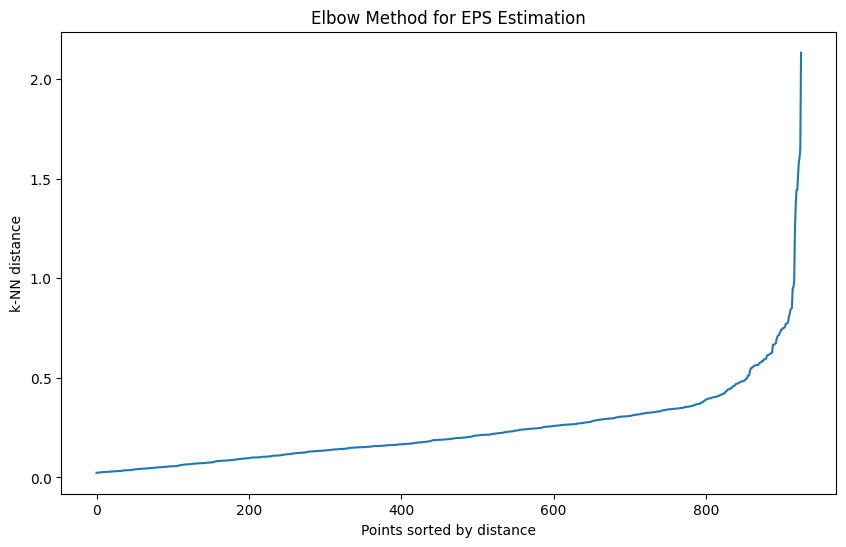

[-1  0  1  0 -1  0 -1 -1 -1 -1 -1 -1 -1 -1  0  0 -1 -1 -1  0 -1  1 -1  0
 -1  0 -1  0  2 -1 -1 -1 -1  0  2 -1 -1  2 -1  1 -1 -1 -1 -1 -1 -1  2 -1
 -1 -1  0  0  0 -1  0 -1 -1  0 -1 -1  0  0  2 -1 -1 -1 -1 -1 -1 -1  1  1
 -1 -1  0 -1 -1 -1  0 -1 -1  0 -1 -1 -1  0 -1 -1  1 -1 -1 -1 -1 -1  0 -1
 -1 -1  0 -1  0 -1  1 -1  0 -1  0 -1  1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1  1 -1  0 -1 -1 -1 -1  0  0 -1  0  0  0  0  0 -1  0 -1 -1 -1  0 -1
  0  0  2 -1 -1  0 -1 -1 -1  0  1 -1 -1 -1 -1 -1  1  0  0 -1 -1 -1  0  2
  0 -1 -1 -1 -1 -1 -1 -1 -1  0 -1  1  2  0 -1 -1 -1  1 -1 -1 -1 -1 -1 -1
 -1  0 -1 -1  2 -1 -1  0  0 -1  0  0  0 -1 -1 -1 -1  2  0 -1 -1 -1  0  0
 -1 -1 -1 -1 -1 -1  0 -1 -1 -1  0  0  1 -1 -1 -1 -1 -1  0  1 -1 -1 -1 -1
 -1  2 -1  0  1 -1 -1  1 -1 -1  0 -1 -1  2  0  0  0 -1 -1 -1 -1  0 -1 -1
  0  0  0  0  0  0 -1  0  2  2 -1  0 -1 -1  0 -1  0  0 -1 -1 -1 -1  1 -1
 -1 -1 -1  0  0  0 -1 -1  0 -1 -1  0 -1  0 -1  0 -1  0 -1 -1 -1 -1 -1 -1
 -1  0  2  0 -1 -1  0  0  0  2 -1  0  1 -1 -1 -1 -1

C:\Users\emrey\AppData\Local\Temp\ipykernel_20200\3093054951.py:52: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('plasma', np.unique(cluster_labels).max() + 1)


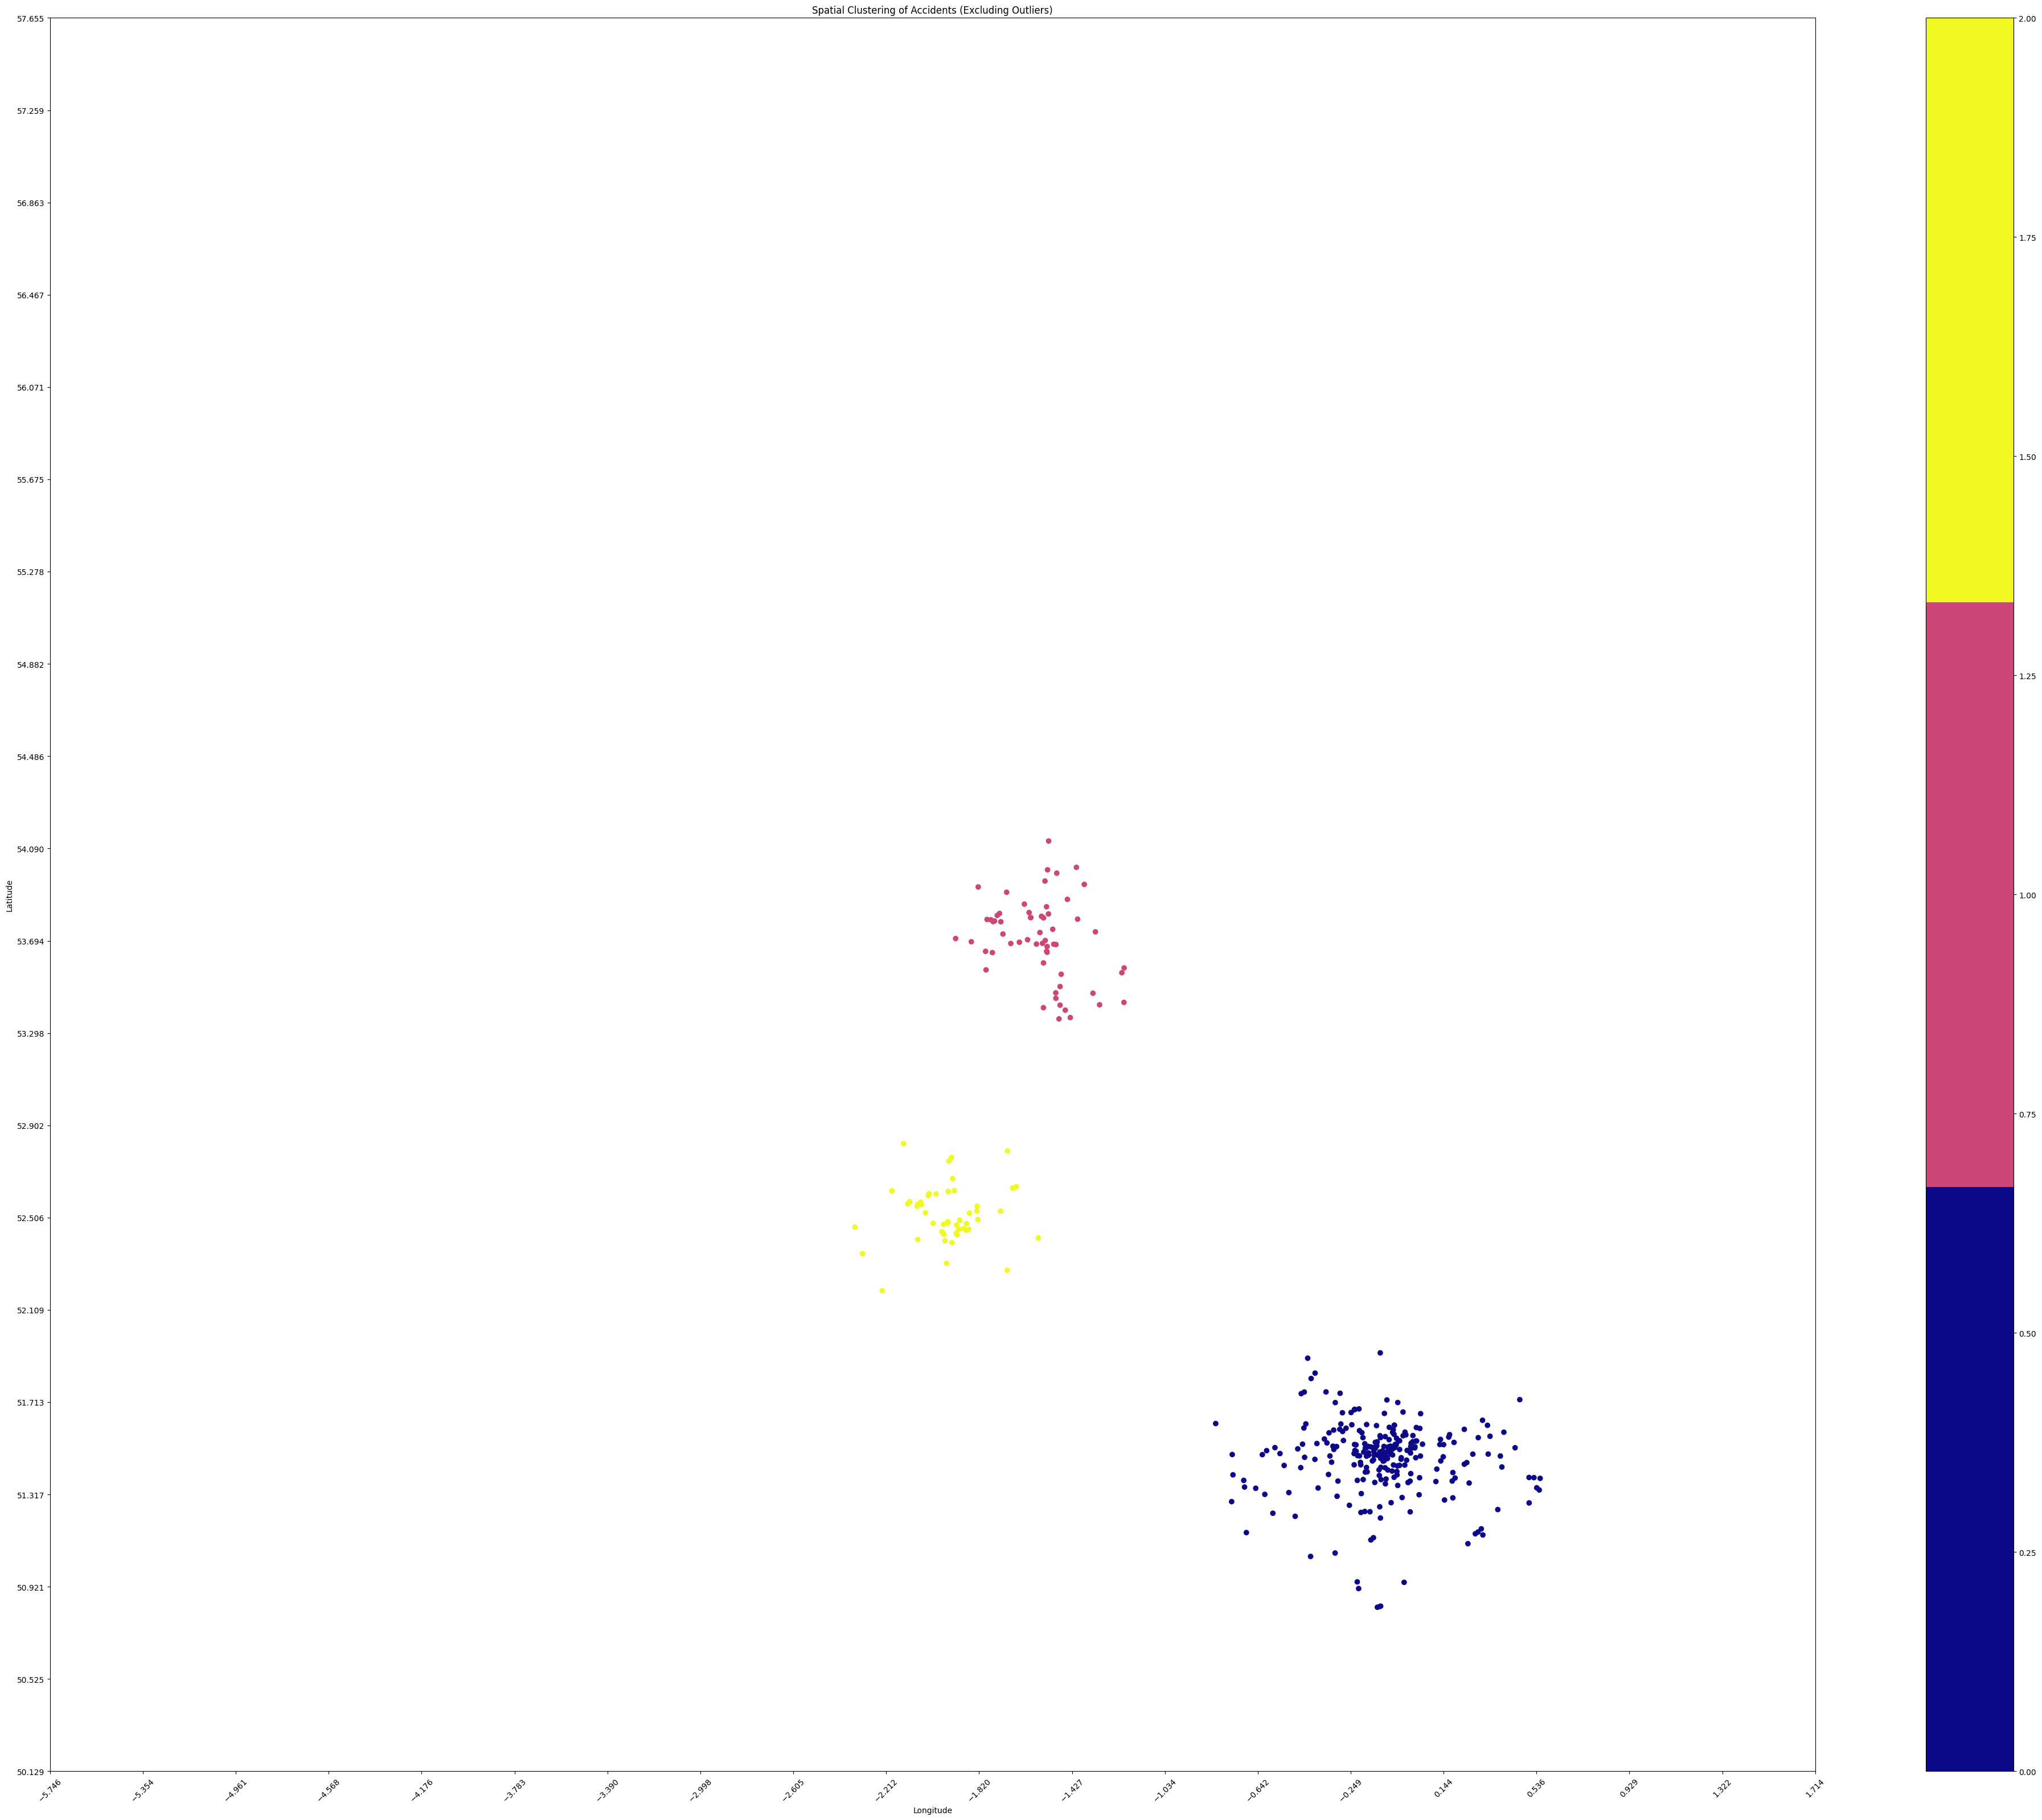

Cluster 0:
  Min Longitude: -0.819601
  Max Longitude: 0.551526
  Min Latitude: 50.833168
  Max Latitude: 51.925049

Cluster 1:
  Min Longitude: -1.918695
  Max Longitude: -1.206629
  Min Latitude: 53.358557
  Max Latitude: 54.122137

Cluster 2:
  Min Longitude: -2.344088
  Max Longitude: -1.569288
  Min Latitude: 52.191757
  Max Latitude: 52.823035



In [14]:
import numpy as np
import matplotlib.pyplot as plt



def k_nearest_neighbors(X, k):
    distances = np.zeros((len(X), k))

    for i in range(len(X)):
        all_distances = np.array([euclidean_distance(X[i], X[j]) for j in range(len(X)) if i != j])
        sorted_distances = np.sort(all_distances)
        distances[i, :] = sorted_distances[:k]
    
    return distances

# Apply DBScan with Longtitude and Latitude columns
coordinates = df[['longitude', 'latitude']].values

# Applying Elbow Method Beginning
k = 10
knn_distances = k_nearest_neighbors(coordinates, k)

# Take the furthest k-NN distance and order
knn_distances = knn_distances[:, k-1]
knn_distances = np.sort(knn_distances, axis=0)

plt.figure(figsize=(10, 6))
plt.plot(knn_distances)
plt.xlabel('Points sorted by distance')
plt.ylabel('k-NN distance')
plt.title('Elbow Method for EPS Estimation')
plt.show()
# Applying Elbow Method End



# Clustering
labels = dbscan(coordinates, eps=0.3, min_samples=40)
print(labels)
# Print the number of samples in each cluster
unique_labels = np.unique(labels)
for label in unique_labels:
    if(label!=-1):
        print(f'Cluster {label} contains {np.sum(labels == label)} samples')

plt.figure(figsize=(50, 40))

# Filter out the outliers (label -1)
clustered_data = coordinates[labels != -1]
cluster_labels = labels[labels != -1]

cmap = plt.cm.get_cmap('plasma', np.unique(cluster_labels).max() + 1)
plt.scatter(clustered_data[:, 0], clustered_data[:, 1], c=cluster_labels, cmap=cmap, marker='o')

plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Spatial Clustering of Accidents (Excluding Outliers)')
x_min, x_max = coordinates[:, 0].min(), coordinates[:, 0].max()
y_min, y_max = coordinates[:, 1].min(), coordinates[:, 1].max()

plt.xticks(np.linspace(x_min, x_max, num=20), rotation=45)
plt.yticks(np.linspace(y_min, y_max, num=20)) 
plt.colorbar()
plt.show()


cluster_stats = {}

for label in unique_labels:
    # Get Latitude and Longtitude for each cluster
    cluster_coordinates = coordinates[labels == label]
    
    # Calculate stats
    min_longitude, max_longitude = cluster_coordinates[:, 0].min(), cluster_coordinates[:, 0].max()
    min_latitude, max_latitude = cluster_coordinates[:, 1].min(), cluster_coordinates[:, 1].max()

    # Add stats to the dictionary
    cluster_stats[label] = {
        "min_longitude": min_longitude,
        "max_longitude": max_longitude,
        "min_latitude": min_latitude,
        "max_latitude": max_latitude
    }

# Print stats
for label, stats in cluster_stats.items():
    if(label!=-1):
        print(f"Cluster {label}:")
        print(f"  Min Longitude: {stats['min_longitude']}")
        print(f"  Max Longitude: {stats['max_longitude']}")
        print(f"  Min Latitude: {stats['min_latitude']}")
        print(f"  Max Latitude: {stats['max_latitude']}\n")


Clustering using 'vehicle_manoeuvre', 'pedestrian_movement', 'vehicle_location-restricted_lane', 'junction_location' allows for a detailed analysis of the interaction between driver behavior, pedestrian movement, and road infrastructure in causing accidents. It can provide actionable insights for improving road safety and reducing accident rates.

['vehicle_manoeuvre_1', 'vehicle_manoeuvre_2', 'vehicle_manoeuvre_3', 'vehicle_manoeuvre_4', 'vehicle_manoeuvre_5', 'vehicle_manoeuvre_6', 'vehicle_manoeuvre_7', 'vehicle_manoeuvre_8', 'vehicle_manoeuvre_9', 'vehicle_manoeuvre_10', 'vehicle_manoeuvre_11', 'vehicle_manoeuvre_12', 'vehicle_manoeuvre_13', 'vehicle_manoeuvre_14', 'vehicle_manoeuvre_15', 'vehicle_manoeuvre_16', 'vehicle_manoeuvre_17', 'vehicle_manoeuvre_18', 'pedestrian_movement_0.0', 'pedestrian_movement_1.0', 'pedestrian_movement_2.0', 'pedestrian_movement_3.0', 'pedestrian_movement_4.0', 'pedestrian_movement_5.0', 'pedestrian_movement_7.0', 'pedestrian_movement_9.0', 'vehicle_location-restricted_lane_0', 'vehicle_location-restricted_lane_1', 'vehicle_location-restricted_lane_2', 'vehicle_location-restricted_lane_3', 'vehicle_location-restricted_lane_4', 'vehicle_location-restricted_lane_8', 'vehicle_location-restricted_lane_9', 'junction_location_0', 'junction_location_1', 'junction_location_2', 'junction_location_3', 'j

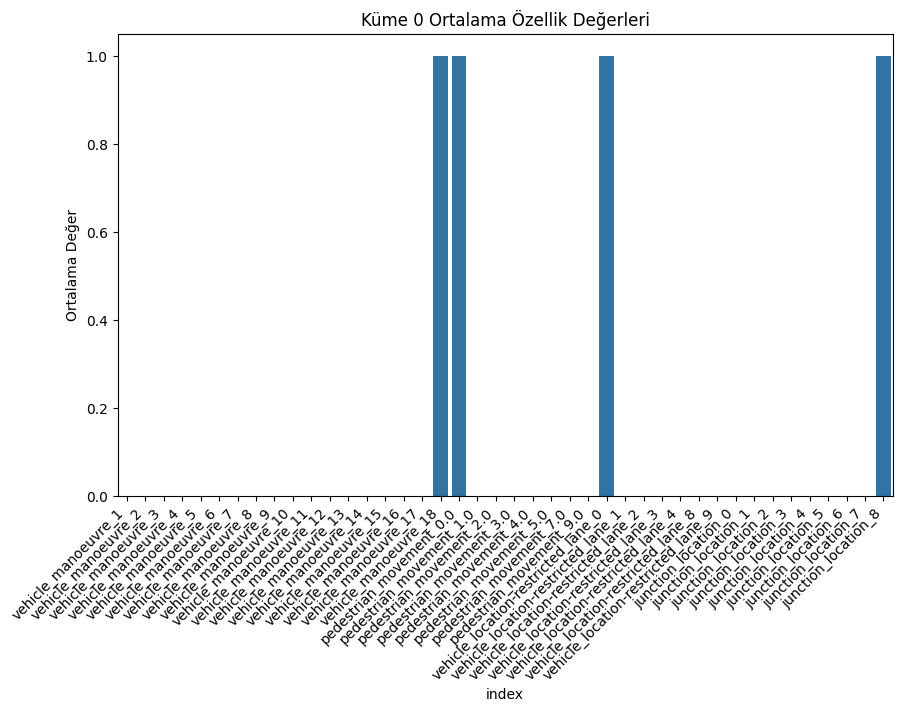

Küme 1 İstatistikleri:
       vehicle_manoeuvre_1 vehicle_manoeuvre_2 vehicle_manoeuvre_3  \
count                   90                  90                  90   
unique                   1                   1                   1   
top                  False               False               False   
freq                    90                  90                  90   

       vehicle_manoeuvre_4 vehicle_manoeuvre_5 vehicle_manoeuvre_6  \
count                   90                  90                  90   
unique                   1                   1                   1   
top                  False               False               False   
freq                    90                  90                  90   

       vehicle_manoeuvre_7 vehicle_manoeuvre_8 vehicle_manoeuvre_9  \
count                   90                  90                  90   
unique                   1                   1                   1   
top                  False               False               Fals

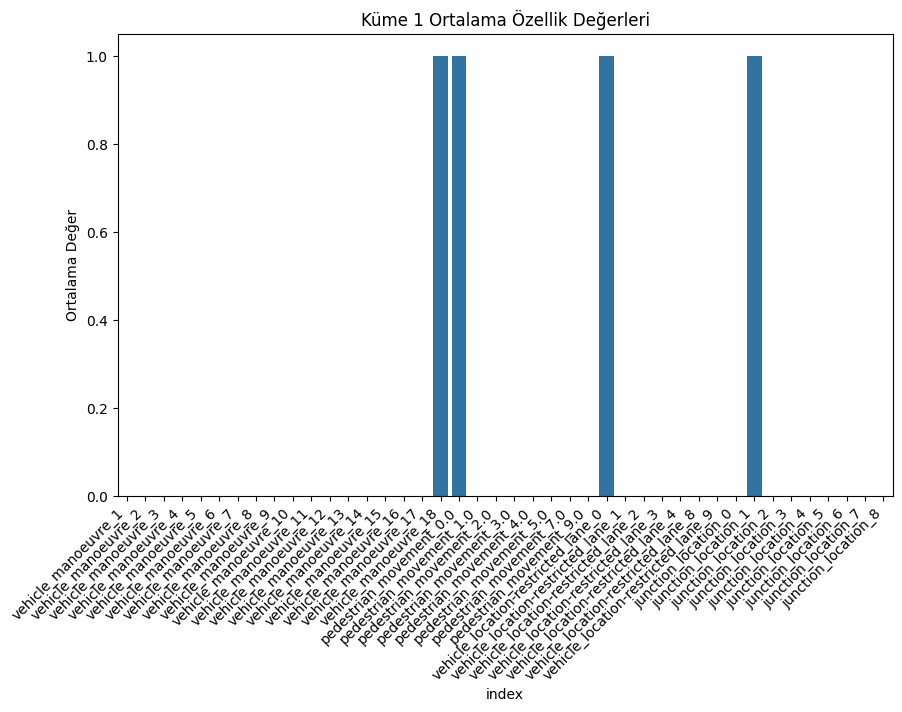

Küme 2 İstatistikleri:
       vehicle_manoeuvre_1 vehicle_manoeuvre_2 vehicle_manoeuvre_3  \
count                  158                 158                 158   
unique                   1                   1                   1   
top                  False               False               False   
freq                   158                 158                 158   

       vehicle_manoeuvre_4 vehicle_manoeuvre_5 vehicle_manoeuvre_6  \
count                  158                 158                 158   
unique                   1                   1                   1   
top                  False               False               False   
freq                   158                 158                 158   

       vehicle_manoeuvre_7 vehicle_manoeuvre_8 vehicle_manoeuvre_9  \
count                  158                 158                 158   
unique                   1                   1                   1   
top                  False               False               Fals

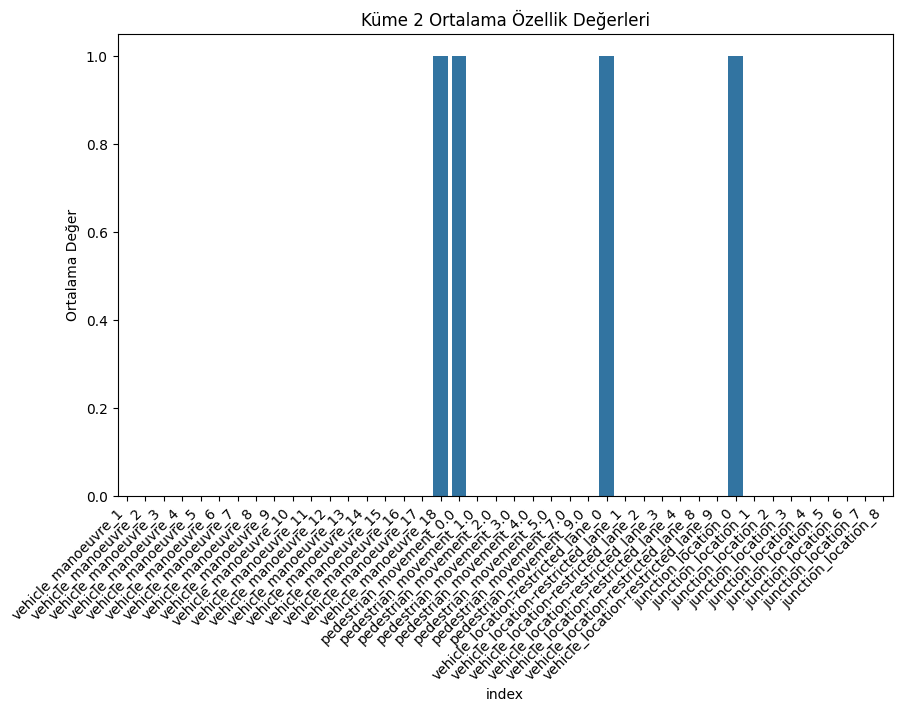

Küme 3 İstatistikleri:
       vehicle_manoeuvre_1 vehicle_manoeuvre_2 vehicle_manoeuvre_3  \
count                   29                  29                  29   
unique                   1                   1                   1   
top                  False               False               False   
freq                    29                  29                  29   

       vehicle_manoeuvre_4 vehicle_manoeuvre_5 vehicle_manoeuvre_6  \
count                   29                  29                  29   
unique                   1                   1                   1   
top                  False               False               False   
freq                    29                  29                  29   

       vehicle_manoeuvre_7 vehicle_manoeuvre_8 vehicle_manoeuvre_9  \
count                   29                  29                  29   
unique                   1                   1                   1   
top                  False               False               Fals

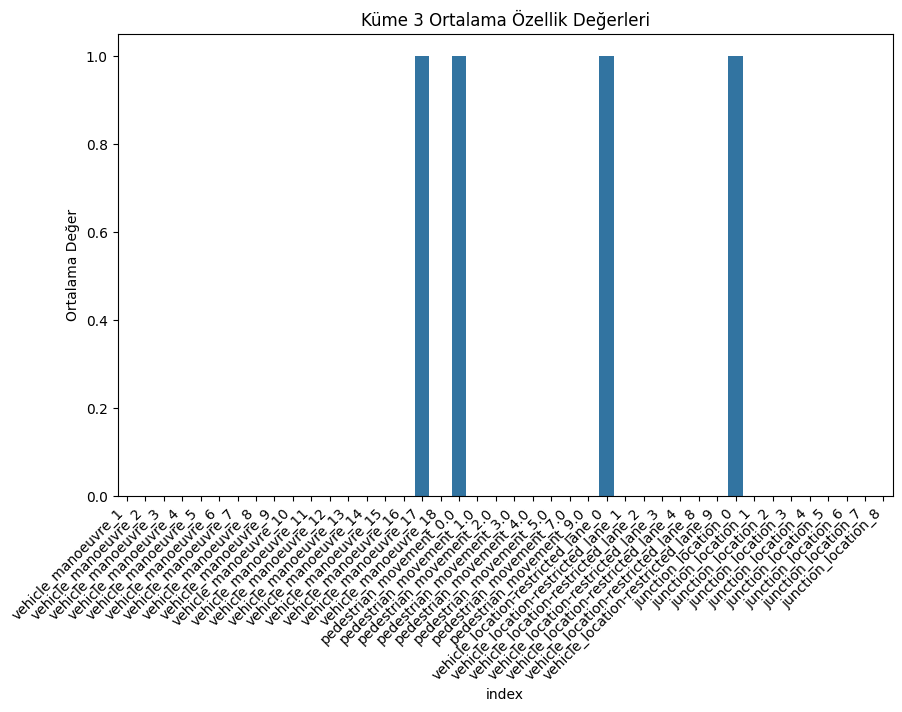

Küme 4 İstatistikleri:
       vehicle_manoeuvre_1 vehicle_manoeuvre_2 vehicle_manoeuvre_3  \
count                   31                  31                  31   
unique                   1                   1                   1   
top                  False               False               False   
freq                    31                  31                  31   

       vehicle_manoeuvre_4 vehicle_manoeuvre_5 vehicle_manoeuvre_6  \
count                   31                  31                  31   
unique                   1                   1                   1   
top                   True               False               False   
freq                    31                  31                  31   

       vehicle_manoeuvre_7 vehicle_manoeuvre_8 vehicle_manoeuvre_9  \
count                   31                  31                  31   
unique                   1                   1                   1   
top                  False               False               Fals

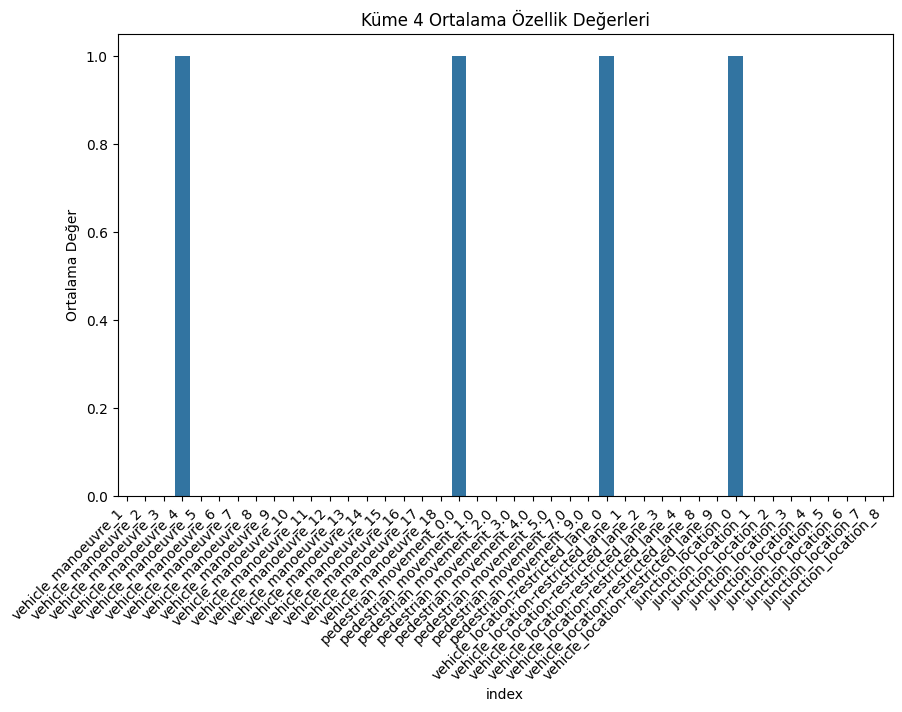

Küme 5 İstatistikleri:
       vehicle_manoeuvre_1 vehicle_manoeuvre_2 vehicle_manoeuvre_3  \
count                   28                  28                  28   
unique                   1                   1                   1   
top                  False               False                True   
freq                    28                  28                  28   

       vehicle_manoeuvre_4 vehicle_manoeuvre_5 vehicle_manoeuvre_6  \
count                   28                  28                  28   
unique                   1                   1                   1   
top                  False               False               False   
freq                    28                  28                  28   

       vehicle_manoeuvre_7 vehicle_manoeuvre_8 vehicle_manoeuvre_9  \
count                   28                  28                  28   
unique                   1                   1                   1   
top                  False               False               Fals

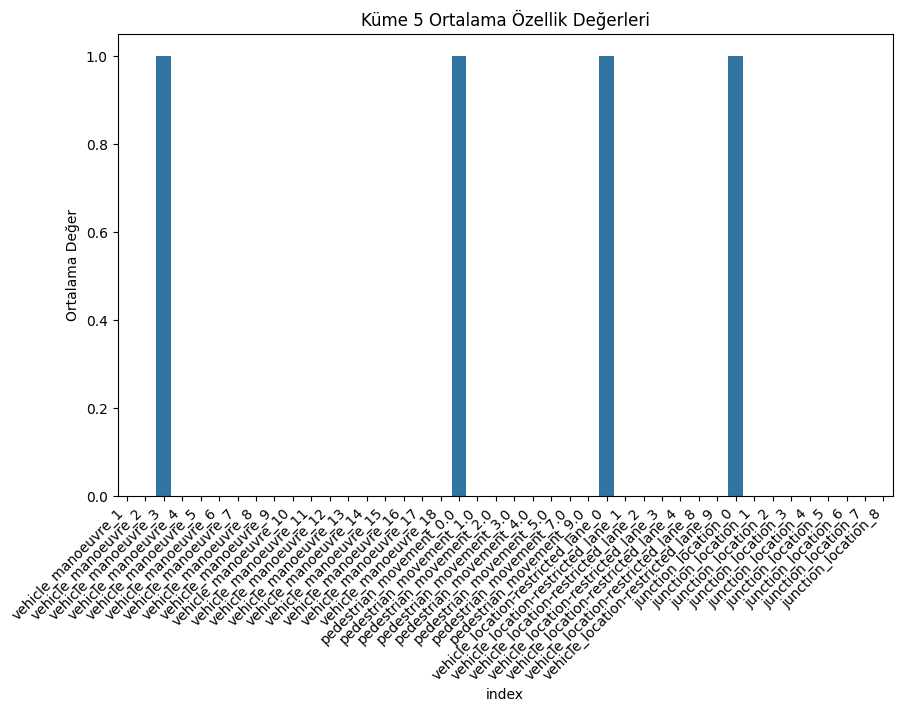

In [15]:
from sklearn.metrics import silhouette_score

# Select one-hot encoded columns
selected_columns = ['vehicle_manoeuvre', 'pedestrian_movement', 'vehicle_location-restricted_lane', 'junction_location']
encoded_columns = [col for col in df_encoded.columns if any(col.startswith(c) for c in selected_columns)]
print(encoded_columns)
features = df_encoded[encoded_columns].values

eps_values = [0.1, 5, 0.005, 0.05, 2] 
min_samples = 25
best_eps = eps_values[0]
best_score = -1

for eps in eps_values:
    labels = dbscan(features, eps, min_samples)
    if len(np.unique(labels)) > 1:  # At least there must be two cluster excluding outliers
        score = silhouette_score(features, labels)
        if score > best_score:
            best_score = score
            best_eps = eps

print(f'En iyi EPS: {best_eps}, Silhouette Skoru: {best_score}')


eps_values = [0.1, 5, 0.005, 0.05, 2]
min_samples = 15
best_eps = eps_values[0]
best_score = -1

for eps in eps_values:
    labels = dbscan(features, eps, min_samples)
    if len(np.unique(labels)) > 1:  # At least there must be two cluster excluding outliers
        score = silhouette_score(features, labels)
        if score > best_score:
            best_score = score
            best_eps = eps

print(f'En iyi EPS: {best_eps}, Silhouette Skoru: {best_score}')

eps_values = [0.1, 5, 0.005, 0.05, 2]
min_samples = 35
best_eps = eps_values[0]
best_score = -1

for eps in eps_values:
    labels = dbscan(features, eps, min_samples)
    if len(np.unique(labels)) > 1:  # At least there must be two cluster excluding outliers
        score = silhouette_score(features, labels)
        if score > best_score:
            best_score = score
            best_eps = eps

print(f'En iyi EPS: {best_eps}, Silhouette Skoru: {best_score}')

labels = dbscan(features,eps=0.1, min_samples=25)

from sklearn.decomposition import PCA

from sklearn.metrics import silhouette_score




# # Perform PCA for visualization
# pca = PCA(n_components=2)
# reduced_data = pca.fit_transform(features)
# unique_labels = np.unique(labels)

# # Plot the clusters excluding outliers (-1 labels)
# plt.figure(figsize=(8, 6))
# for label in unique_labels:
#     if label != -1:  # Aykırı değerleri dışarıda tut
#         plt.scatter(reduced_data[labels == label, 0], reduced_data[labels == label, 1], label=f'Cluster {label}')
# plt.title('DBSCAN Clustering Visualization (Excluding Outliers)')
# plt.xlabel('PCA Feature 1')
# plt.ylabel('PCA Feature 2')
# plt.legend()
# plt.show()



import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Count cluster labels
(unique, counts) = np.unique(labels, return_counts=True)
frequencies = np.asarray((unique, counts)).T

# Print the number of samples in each cluster
for label in unique:
    print(f'Cluster {label} contains {np.sum(labels == label)} samples')



# Calculate stats for each cluster and visualize
for cluster in np.unique(labels):
    if cluster != -1:  # Exclude outliers
        cluster_features = df_encoded[encoded_columns][labels == cluster]
        cluster_summary = cluster_features.describe()
        print(f"Küme {cluster} İstatistikleri:")
        print(cluster_summary)

        plt.figure(figsize=(10, 6))
        sns.barplot(data=cluster_features.mean().reset_index(), x='index', y=0)
        plt.title(f'Küme {cluster} Ortalama Özellik Değerleri')
        plt.xticks(rotation=45, ha='right')
        plt.ylabel('Ortalama Değer')
        plt.show()




Cluster -1 contains 168 samples
Cluster 0 contains 25 samples
Cluster 1 contains 446 samples
Cluster 2 contains 48 samples
Cluster 3 contains 42 samples
Cluster 4 contains 19 samples
Cluster 5 contains 84 samples
Cluster 6 contains 78 samples
Cluster 7 contains 16 samples
Küme 0 İstatistikleri:
       accident_severity_1 accident_severity_2 accident_severity_3  \
count                   25                  25                  25   
unique                   1                   1                   1   
top                  False               False                True   
freq                    25                  25                  25   

       weather_conditions_1 weather_conditions_2 weather_conditions_3  \
count                    25                   25                   25   
unique                    1                    1                    1   
top                    True                False                False   
freq                     25                   25             

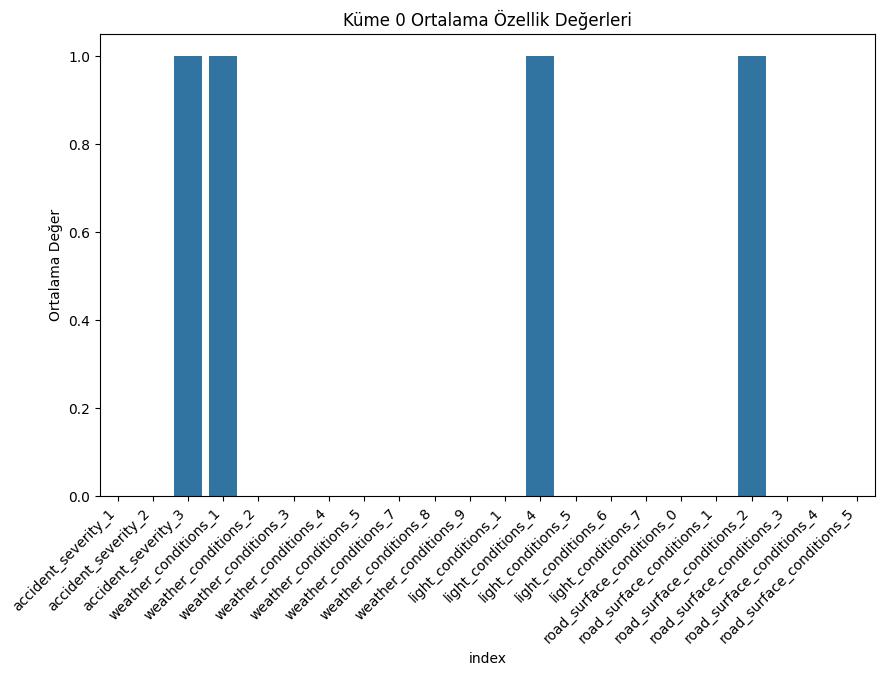

Küme 1 İstatistikleri:
       accident_severity_1 accident_severity_2 accident_severity_3  \
count                  446                 446                 446   
unique                   1                   1                   1   
top                  False               False                True   
freq                   446                 446                 446   

       weather_conditions_1 weather_conditions_2 weather_conditions_3  \
count                   446                  446                  446   
unique                    1                    1                    1   
top                    True                False                False   
freq                    446                  446                  446   

       weather_conditions_4 weather_conditions_5 weather_conditions_7  \
count                   446                  446                  446   
unique                    1                    1                    1   
top                   False              

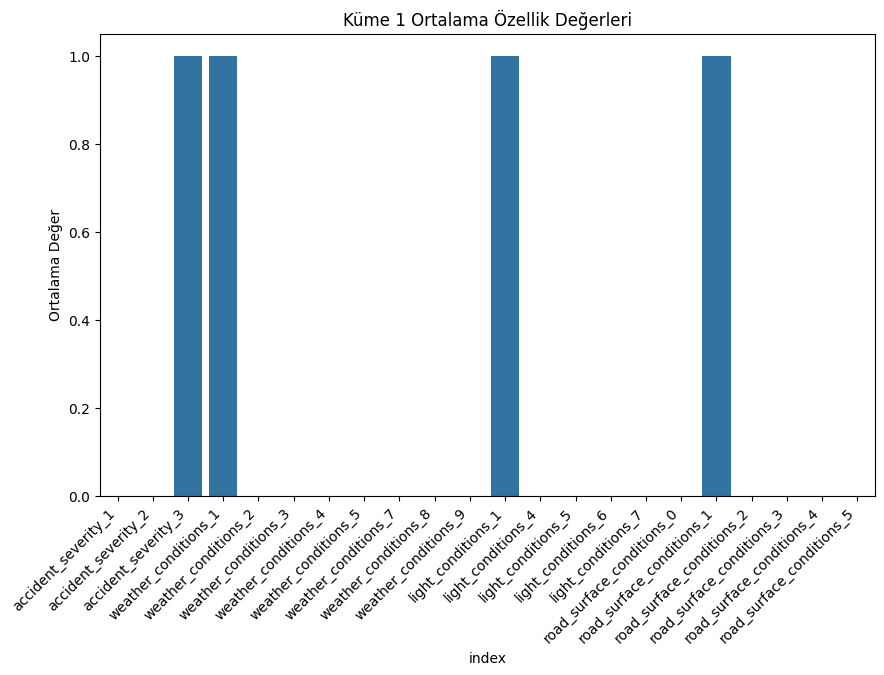

Küme 2 İstatistikleri:
       accident_severity_1 accident_severity_2 accident_severity_3  \
count                   48                  48                  48   
unique                   1                   1                   1   
top                  False               False                True   
freq                    48                  48                  48   

       weather_conditions_1 weather_conditions_2 weather_conditions_3  \
count                    48                   48                   48   
unique                    1                    1                    1   
top                   False                 True                False   
freq                     48                   48                   48   

       weather_conditions_4 weather_conditions_5 weather_conditions_7  \
count                    48                   48                   48   
unique                    1                    1                    1   
top                   False              

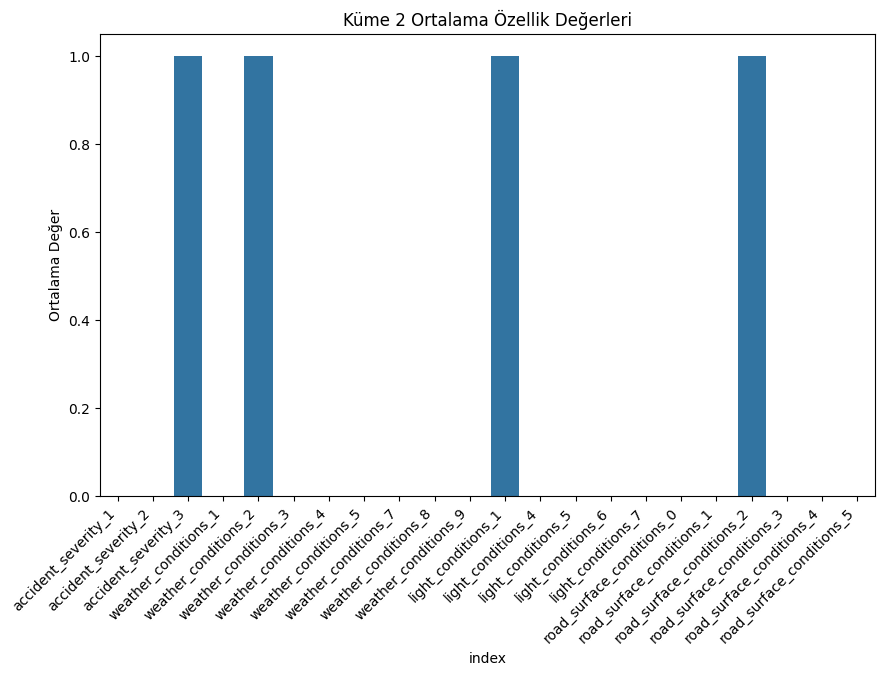

Küme 3 İstatistikleri:
       accident_severity_1 accident_severity_2 accident_severity_3  \
count                   42                  42                  42   
unique                   1                   1                   1   
top                  False               False                True   
freq                    42                  42                  42   

       weather_conditions_1 weather_conditions_2 weather_conditions_3  \
count                    42                   42                   42   
unique                    1                    1                    1   
top                    True                False                False   
freq                     42                   42                   42   

       weather_conditions_4 weather_conditions_5 weather_conditions_7  \
count                    42                   42                   42   
unique                    1                    1                    1   
top                   False              

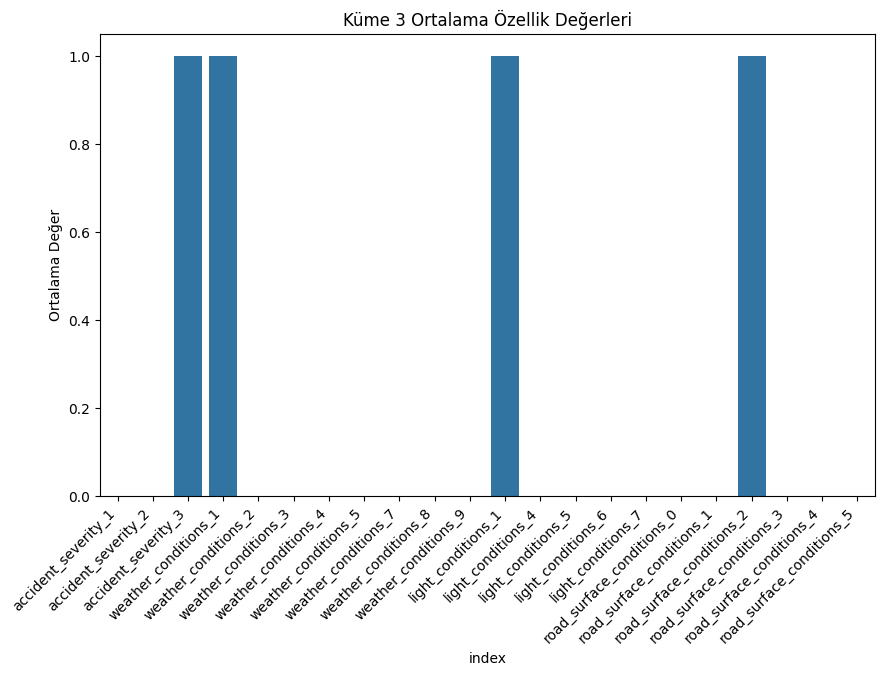

Küme 4 İstatistikleri:
       accident_severity_1 accident_severity_2 accident_severity_3  \
count                   19                  19                  19   
unique                   1                   1                   1   
top                  False               False                True   
freq                    19                  19                  19   

       weather_conditions_1 weather_conditions_2 weather_conditions_3  \
count                    19                   19                   19   
unique                    1                    1                    1   
top                   False                 True                False   
freq                     19                   19                   19   

       weather_conditions_4 weather_conditions_5 weather_conditions_7  \
count                    19                   19                   19   
unique                    1                    1                    1   
top                   False              

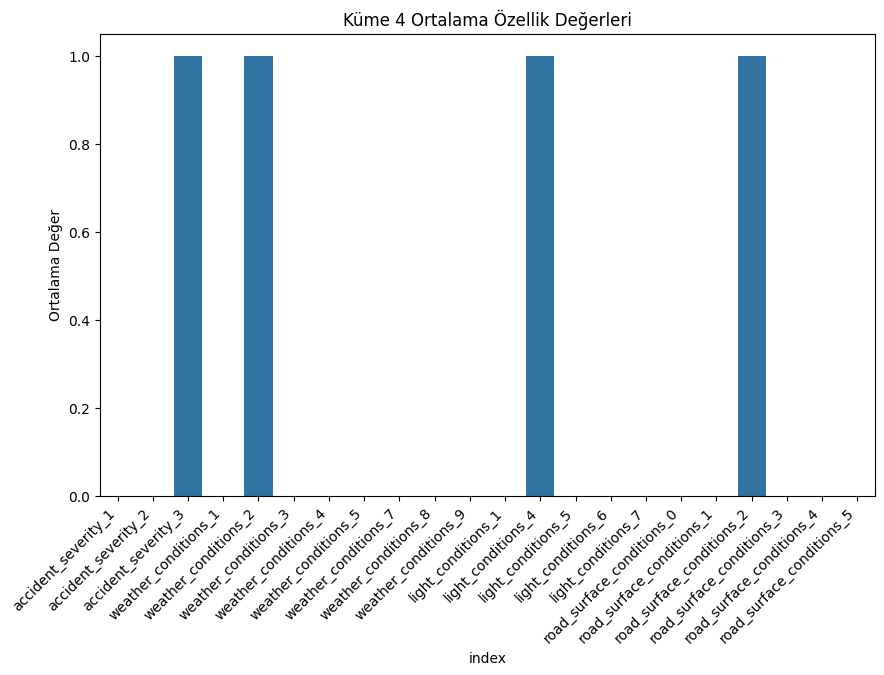

Küme 5 İstatistikleri:
       accident_severity_1 accident_severity_2 accident_severity_3  \
count                   84                  84                  84   
unique                   1                   1                   1   
top                  False                True               False   
freq                    84                  84                  84   

       weather_conditions_1 weather_conditions_2 weather_conditions_3  \
count                    84                   84                   84   
unique                    1                    1                    1   
top                    True                False                False   
freq                     84                   84                   84   

       weather_conditions_4 weather_conditions_5 weather_conditions_7  \
count                    84                   84                   84   
unique                    1                    1                    1   
top                   False              

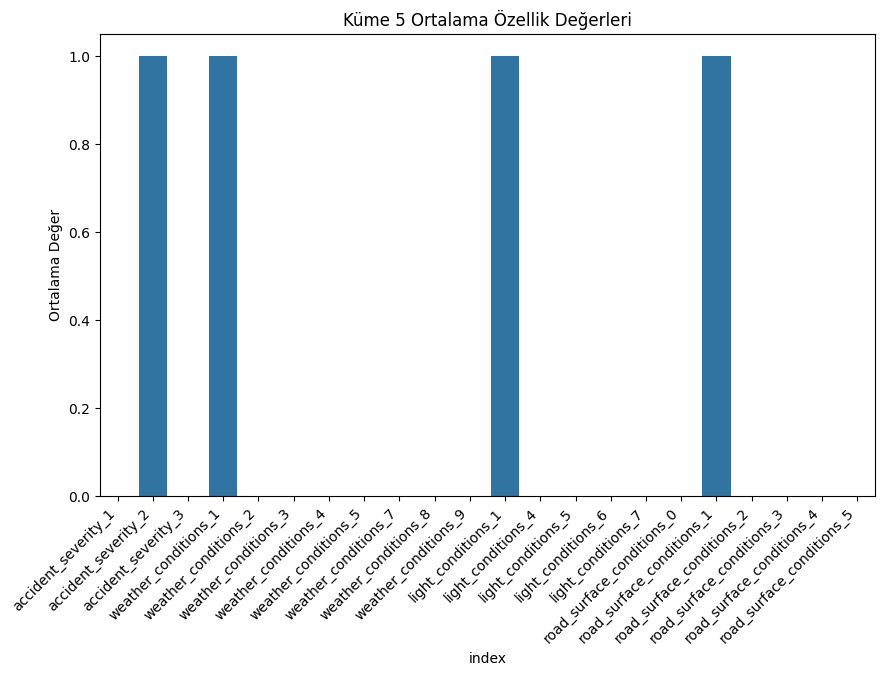

Küme 6 İstatistikleri:
       accident_severity_1 accident_severity_2 accident_severity_3  \
count                   78                  78                  78   
unique                   1                   1                   1   
top                  False               False                True   
freq                    78                  78                  78   

       weather_conditions_1 weather_conditions_2 weather_conditions_3  \
count                    78                   78                   78   
unique                    1                    1                    1   
top                    True                False                False   
freq                     78                   78                   78   

       weather_conditions_4 weather_conditions_5 weather_conditions_7  \
count                    78                   78                   78   
unique                    1                    1                    1   
top                   False              

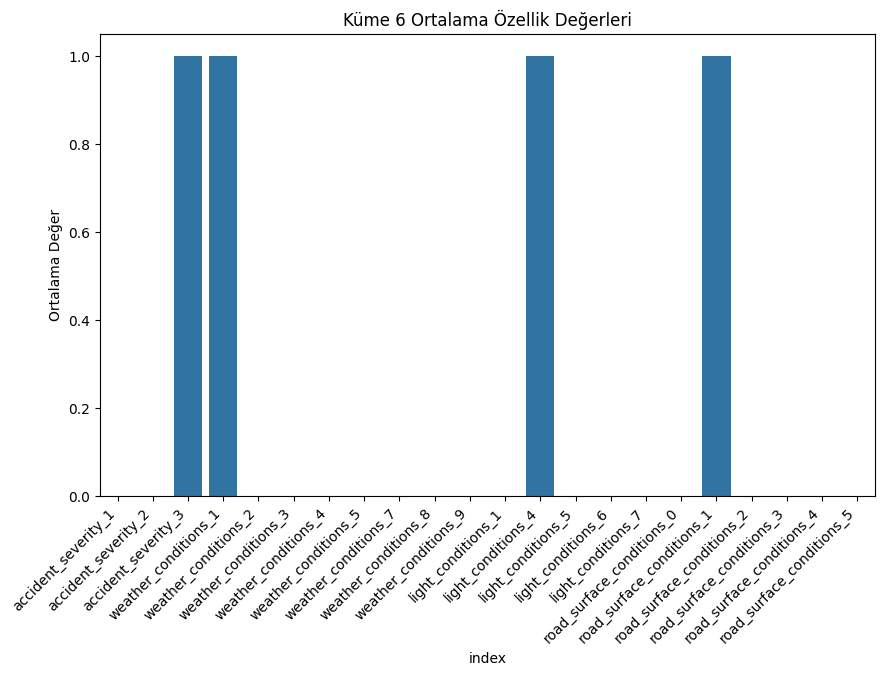

Küme 7 İstatistikleri:
       accident_severity_1 accident_severity_2 accident_severity_3  \
count                   16                  16                  16   
unique                   1                   1                   1   
top                  False                True               False   
freq                    16                  16                  16   

       weather_conditions_1 weather_conditions_2 weather_conditions_3  \
count                    16                   16                   16   
unique                    1                    1                    1   
top                    True                False                False   
freq                     16                   16                   16   

       weather_conditions_4 weather_conditions_5 weather_conditions_7  \
count                    16                   16                   16   
unique                    1                    1                    1   
top                   False              

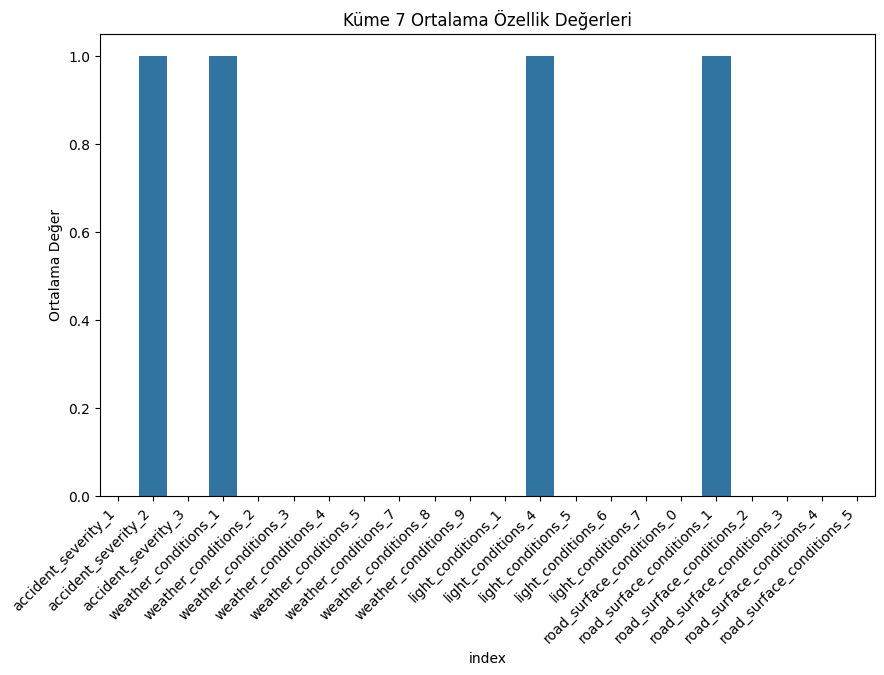

In [20]:
# Select one-hot encoded columns
selected_columns = ['accident_severity', 'weather_conditions', 'light_conditions', 'road_surface_conditions']
encoded_columns = [col for col in df_encoded.columns if any(col.startswith(c) for c in selected_columns)]

features = df_encoded[encoded_columns].values

# eps_values = [0.1, 5, 0.005, 0.05, 0.5]  # Örnek eps değerleri
# min_samples = 25
# best_eps = eps_values[0]
# best_score = -1

# for eps in eps_values:
#     labels = dbscan(features, eps, min_samples)
#     if len(np.unique(labels)) > 1: 
#         score = silhouette_score(features, labels)
#         if score > best_score:
#             best_score = score
#             best_eps = eps

# print(f'En iyi EPS: {best_eps}, Silhouette Skoru: {best_score}')


# eps_values = [0.1, 5, 0.005, 0.05, 0.5]  
# min_samples = 15
# best_eps = eps_values[0]
# best_score = -1

# for eps in eps_values:
#     labels = dbscan(features, eps, min_samples)
#     if len(np.unique(labels)) > 1: 
#         score = silhouette_score(features, labels)
#         if score > best_score:
#             best_score = score
#             best_eps = eps

# print(f'En iyi EPS: {best_eps}, Silhouette Skoru: {best_score}')

# eps_values = [0.1, 5, 0.005, 0.05, 0.5] 
# min_samples = 35
# best_eps = eps_values[0]
# best_score = -1

# for eps in eps_values:
#     labels = dbscan(features, eps, min_samples)
#     if len(np.unique(labels)) > 1:
#         score = silhouette_score(features, labels)
#         if score > best_score:
#             best_score = score
#             best_eps = eps

# print(f'En iyi EPS: {best_eps}, Silhouette Skoru: {best_score}')



labels = dbscan(features, eps=0.1, min_samples=15)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Count cluster labels
(unique, counts) = np.unique(labels, return_counts=True)
frequencies = np.asarray((unique, counts)).T

# Print the number of samples in each cluster
for label in unique:
    print(f'Cluster {label} contains {np.sum(labels == label)} samples')


# Calculate stats for each cluster and visualize
for cluster in np.unique(labels):
    if cluster != -1:  # Exclude outliers
        cluster_features = df_encoded[encoded_columns][labels == cluster]
        cluster_summary = cluster_features.describe()
        print(f"Küme {cluster} İstatistikleri:")
        print(cluster_summary)

        plt.figure(figsize=(10, 6))
        sns.barplot(data=cluster_features.mean().reset_index(), x='index', y=0)
        plt.title(f'Küme {cluster} Ortalama Özellik Değerleri')
        plt.xticks(rotation=45, ha='right')
        plt.ylabel('Ortalama Değer')
        plt.show()



In [19]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

# Create the logistic regression model
log_reg = LogisticRegression()

# Train the model on the balanced training data
log_reg.fit(X_train_balanced, y_train_balanced)

# Predict on the test data
log_reg_predictions = log_reg.predict(X_test)

# Calculate the accuracy
log_reg_accuracy = accuracy_score(y_test, log_reg_predictions)

# Print the accuracy
print(f"Logistic Regression Accuracy: {log_reg_accuracy}")


Logistic Regression Accuracy: 0.7877697841726619


c:\Users\emrey\OneDrive\Masaüstü\data_mining\dm\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
